<a href="https://colab.research.google.com/github/solevillar/scGeneFit-python/blob/master/scGeneFit_large_scale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import itertools
from scGeneFit.functions import *
np.random.seed(0)

In [2]:
#Definition of functional groups
#f_groups={functional_group_id: [mean1, mean2, ...], ...} where mean=[gene1,gene2, ...]
f_groups={0:[[0,0], [1,0], [0,1], [1,1]], 1: [[0],[1]], 2: [[0,0], [0,1], [1,0], [1,1]], 3:[[0,0], [1,0], [0,1], [1,1]], 4: [[0],[1]], 
          5: [[0,0], [0,1], [1,0], [1,1]], 6:[[0,1], [1,0], [0,1], [1,1]], 7: [[2,2],[3,3]], 8: [[0,0], [0,4], [4,0], [4,4]],
          9:[[0,0], [1,0], [0,1], [1,1]], 10: [[0],[1],[2],[4]], 11: [[0,0], [0,1], [1,0], [1,1]],
          12:[[0,0], [1,0], [0,1], [1,1]], 13: [[0],[1]], 14: [[0,0], [0,1], [1,0], [1,1]]}


In [3]:
def create_data(f_groups, cell_types, sigma, n, repeat):
    aux=list(f_groups.keys())
    data=np.zeros( (0, sum([len(f_groups[aux[i]][0])*repeat[i] for i in range(len(aux))]) ))
    for cell in cell_types:
        expression=np.zeros((n, 0))
        for t in range(len(cell)):
            mean=f_groups[t][cell[t]]
            mean=np.concatenate([[mean[i]]*repeat[t] for i in range(len(mean))])
            expression=np.concatenate([expression, np.random.multivariate_normal(mean, sigma*np.identity(len(mean)), size=n)], axis=1)
        data=np.concatenate([data, expression])
    labels=np.concatenate([[i]*n for i in range(len(cell_types))])
    return data,labels

In [4]:
#create data
classes=40
n=25
n_groups=len(list(f_groups.keys()))
cell_types = np.zeros((classes, n_groups))
for i in range(n_groups):
    aux=np.random.permutation(classes)
    idx=list(f_groups.keys())[i]
    n_means=len(f_groups[idx])
    start=0
    offset=int(classes/n_means)
    for s in range(n_means):
        cell_types[aux[start:start+offset], i] = s
        start=start+offset+1
cell_types=cell_types.astype(int)

Text(0, 0.5, 'synthetic cells')

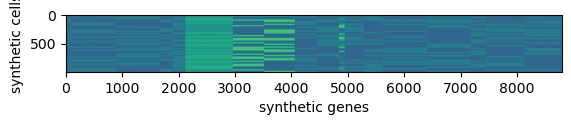

In [5]:
repeat=[10,10,10,10,10]+[np.random.randint(100, 800) for i in range(len(f_groups.keys())-5)]

sc_gene, sc_labels=create_data(f_groups, cell_types, 0.5, n, repeat)
plt.imshow(sc_gene)
plt.xlabel('synthetic genes')
plt.ylabel('synthetic cells')

In [6]:
#create data
print(sc_gene.shape)
X_train, y_train= sc_gene, sc_labels
X_test, y_test= X_train, y_train


(1000, 8798)


In [7]:
#Choose an evaluation method (e.g. classification accuracy)
from sklearn.neighbors import NearestCentroid
clf=NearestCentroid()

def performance(X_train, y_train, X_test, y_test, clf):
    clf.fit(X_train, y_train)
    return clf.score(X_test, y_test)

In [8]:
markers_ova=one_vs_all_selection(X_train,y_train)
one_vs_all_accuracy=performance(X_train[:,markers_ova], y_train, X_test[:,markers_ova], y_test, clf)
print(one_vs_all_accuracy)

0.775


In [9]:
m_range=range(25,55,5)

#obtain markers
#one vs all:
opt_epsilon=[0.05 for i in m_range]


#scGeneFit
markers_lp=[]
accuracy_list=[]
for m, epsilon in zip(m_range, opt_epsilon):
    aux=get_markers(X_train, y_train, m, method='centers', redundancy=.002, epsilon=epsilon)
    markers_lp= markers_lp + [aux]
    
    accuracy = performance(X_train[:,aux], y_train, X_test[:,aux], y_test, clf)
    print("markers:", m, "accuracy:", accuracy)
    accuracy_list+=[accuracy]
    

Solving a linear program with 8798 variables and 43 constraints
Time elapsed: 1.456153154373169 seconds
markers: 25 accuracy: 0.623
Solving a linear program with 8798 variables and 41 constraints
Time elapsed: 5.00743293762207 seconds
markers: 30 accuracy: 0.657
Solving a linear program with 8798 variables and 40 constraints
Time elapsed: 1.5490071773529053 seconds
markers: 35 accuracy: 0.782
Solving a linear program with 8798 variables and 43 constraints
Time elapsed: 6.25360369682312 seconds
markers: 40 accuracy: 0.851
Solving a linear program with 8798 variables and 42 constraints
Time elapsed: 5.604511976242065 seconds
markers: 45 accuracy: 0.912
Solving a linear program with 8798 variables and 41 constraints
Time elapsed: 5.980199098587036 seconds
markers: 50 accuracy: 0.908


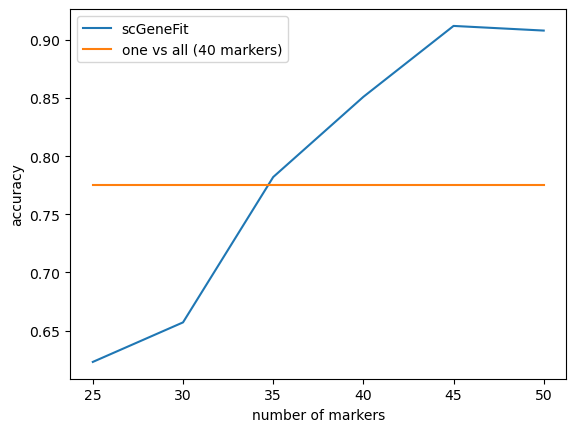

In [10]:
l=accuracy_list

#plot
plt.plot(m_range, l)+plt.plot(m_range,[one_vs_all_accuracy for i in l])
plt.legend(["scGeneFit", "one vs all (40 markers)"])
plt.xlabel("number of markers")
plt.ylabel("accuracy")
plt.savefig("plot.pdf")

